Generalite : 
    La diffusion couvre une gamme de phénomènes qui ont tous comme particularité d'être non réversibles dans le temps. Nous parlerons surtout ici de la diffusion d'un fluide
dans un autre, résultant, en général, en un mélange dont l'homogénéité va croissant avec le phénomène de diffusion, comme le lait dans le café ou le mélange d’azote et d’oxygène de l’atmosphère qui est uniforme et est le résultat d’une diffusion. De façon générale, le résultat est une uniformisation spatiale des différentes concentrations.
    La diffusion peut être causée par une pression appliquée de l’extérieur sur le fluide. Nous attendons alors un terme de source pour décrire cette pression dans l'équation différentielle qui décrit le phénomène. Nous savons aussi qu'une substance en haute concentration locale dans une autre va souvent tendre, si les fluides sont miscibles, à diffuser en tendant vers un mélange homogène. Il peut y avoir ou non une source de nouvelle substance en une région de l'espace, auquel cas un terme de source doit décrire cette situation. La forme exacte des termes de source varie énormément d'une situation à l'autre. 

## Imports

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time

from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [10]:
def solve_1d_diff_pure(u, un, nt, nx, dt, dx, nu):
    for n in range(nt):
      for i in range(nx):
        un[i] = u[i]
      for i in range(1, nx-1):
        u[i] = un[i] + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1]) #la fonction descretisée   
    
    return 0

## Numba accelerator

In [3]:
@njit(fastmath=True) #activation de numba fast math
def solve_1d_diff_numba(u, un, nt, nx, dt, dx, nu):
    for n in range(nt):
        for i in range(nx):
            un[i] = u[i]
        for i in range(1, nx-1):
            u[i] = un[i] + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])    
    return 0

## Pyccel accelerator

In [11]:
def solve_1d_diff_pyccel(u : 'float[:]', un : 'float[:]', nt : 'int', nx : 'int', dt : 'float', dx : 'float', nu : 'float'): #nous avons declarer les variable comme veux les regles de l'art pour l'execution de pyccel accelarator
    
    for n in range(nt):
        for i in range(nx):
            un[i] = u[i]
        for i in range(1, nx-1):
            u[i] = un[i] + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])    
    return 0

## Inputs

Text(0.5, 1.0, '1D Diffusion')

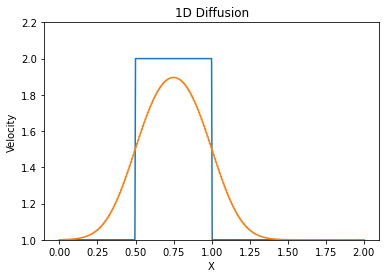

In [12]:
nx = 501
dx = 2 / (nx - 1)
nt = 1500    #the number of timesteps we want to calculate
nu = 0.3   #the value of viscosity
CFL = .5 #sigma is a parameter, we'll learn more about it later
dt = CFL * dx**2 / nu #dt is defined using sigma ... more later!
grid = np.linspace(0,2,nx) # creating the space grid

u0 = np.ones(nx)      #a numpy array with nx elements all equal to 1.
u0[int(.5 / dx):int(1 / dx + 1)] = 2  #setting u = 2 between 0.5 and 1 as per our I.C.s
plt.plot(grid,u0);
u = u0.copy()
un = np.ones(nx) #our placeholder array, un, to advance the solution in time

solve_1d_diff_pure(u, un, nt, nx, dt, dx, nu)
#Plotting data
plt.plot(grid,u);
plt.ylim([1.,2.2])
plt.xlabel('X')
plt.ylabel('Velocity')    
plt.title('1D Diffusion') 

Text(0.5, 1.0, '1D Diffusion')

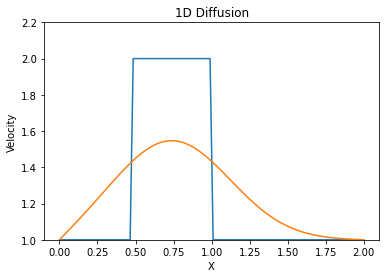

In [13]:
nx = 100
dx = 2 / (nx - 1)
nt = 1500    #the number of timesteps we want to calculate
nu = 0.3   #the value of viscosity
CFL = .1 #sigma is a parameter, we'll learn more about it later
dt = CFL * dx**2 / nu #dt is defined using sigma ... more later!
grid = np.linspace(0,2,nx) # creating the space grid

u0 = np.ones(nx)      #a numpy array with nx elements all equal to 1.
u0[int(.5 / dx):int(1 / dx + 1)] = 2  #setting u = 2 between 0.5 and 1 as per our I.C.s
plt.plot(grid,u0);
u = u0.copy()
un = np.ones(nx) #our placeholder array, un, to advance the solution in time

solve_1d_diff_pure(u, un, nt, nx, dt, dx, nu)
#Plotting data
plt.plot(grid,u);
plt.ylim([1.,2.2])
plt.xlabel('X')
plt.ylabel('Velocity')    
plt.title('1D Diffusion') 

## Call Funtions

### Pure function

In [14]:
%timeit solve_1d_diff_pure(u, un, nt, nx, dt, dx, nu)

443 ms ± 8.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [15]:
%timeit solve_1d_diff_numba(u, un, nt, nx, dt, dx, nu)

391 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Function with pyccel accelerator

In [18]:
solve_1d_diff_f90 = epyccel(solve_1d_diff_pyccel)

In [19]:
%timeit solve_1d_diff_f90(u, un, nt, nx, dt, dx, nu)

376 µs ± 5.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


    Ce qui est constaté pour l'equation de convection est aussi applicable à la fonction de diffusion, nous pouvons constater la difference de temps d'execution qui a ete optimisé en passant par les fonction pure de python(443 ms ± 114 ms per loop) à Numba accelarator(391 µs ± 35.4 µs per loop) et aussi pyccel accelerator(376 µs ± 5.14 µs per loop)
    il faut signaler qu' il a ete constaté aussi que le temps de compilation est plus optimal cette fois avec numba accelerator. 
    une longue reflexion a ete declenché a ce sujet, le constat de cette defaillence de pyccel est que dans l'execution des etape de la simulation de l'equation de diffusion, il y a la presence de certaine etapes intermidiaires qui necessite une (re)declaration des variables dus à la presence de certaines resultats intermidaires en cache.
